In [183]:
import sqlite3
import ipycytoscape
import d3fdgraph
import pandas
import numpy
import networkx as nx
import math
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [184]:
conn = sqlite3.connect("57149d10-831b-4c71-8f51-72497c4e1a50.sqlite")

In [185]:
print ("Opened database successfully")


Opened database successfully


In [186]:
mac_dict = {}
cursor_dst = conn.execute("SELECT DISTINCT ether_dhost from eth")
cursor_src = conn.execute("SELECT DISTINCT ether_shost from eth")
for row in cursor_dst:
    mac_dict[row[0]] = 1
for row in cursor_src:
    mac_dict[row[0]] = 1
    
macs = list(mac_dict.keys())
mac_nodes = []
for mac in macs:
    mac_nodes.append({"data": {"id": mac, "name": mac}})
cursor_edges = conn.execute("SELECT DISTINCT ether_shost, ether_dhost from eth")
mac_edges = []
for edge in cursor_edges:
    mac_edges.append({"data": {"source": edge[0], "target": edge[1]}})
data_macs = {"nodes": mac_nodes, "edges": mac_edges}

In [202]:
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data_macs)
cytoscapeobj.set_layout(name='grid', nodeSpacing=1000, edgeLengthVal=10)
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'background-color': '#11479e',
                            'content': 'data(name)',
                            }
                        },
                        {
                        'selector': 'node:parent',
                        'css': {
                            'background-opacity': 0.1
                            }
                        },
                        {
                            'selector': 'edge',
                            'style': {
                                'width': 2,
                                'line-color': '#9dbaea',
                                'target-arrow-shape': 'triangle',
                                'target-arrow-color': '#9dbaea',
                                'curve-style': 'bezier'
                            }
                        }])
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'grid', 'nodeSpacing': 1000, 'edgeLengthVal': 10}, cytoscape_style=[…

In [188]:
ip_dict = {}
cursor_dst = conn.execute("SELECT DISTINCT ip_dst from ip4")
cursor_src = conn.execute("SELECT DISTINCT ip_src from ip4")
for row in cursor_dst:
    ip_dict[row[0]] = 1
for row in cursor_src:
    ip_dict[row[0]] = 1
    
ips = list(ip_dict.keys())

ip_nodes = []
for ip in ips:
    ip_nodes.append({"data": {"id": ip, "name": ip}})
cursor_edges = conn.execute("SELECT DISTINCT ip_src, ip_dst from ip4")
ip_edges = []
for edge in cursor_edges:
    ip_edges.append({"data": {"source": edge[0], "target": edge[1]}})
data_ips = {"nodes": ip_nodes, "edges": ip_edges}

In [201]:
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(data_ips)
cytoscapeobj.set_layout(name='grid', nodeSpacing=1000, edgeLengthVal=10)
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'background-color': '#11479e',
                            'content': 'data(name)',
                            }
                        },
                        {
                        'selector': 'node:parent',
                        'css': {
                            'background-opacity': 0.1
                            }
                        },
                        {
                            'selector': 'edge',
                            'style': {
                                'width': 2,
                                'line-color': '#9dbaea',
                                'target-arrow-shape': 'triangle',
                                'target-arrow-color': '#9dbaea',
                                'curve-style': 'bezier'
                            }
                        }])
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'grid', 'nodeSpacing': 1000, 'edgeLengthVal': 10}, cytoscape_style=[…

In [190]:
eth_dict = {}
cursor_eth = conn.execute("SELECT DISTINCT hash, ether_shost, ether_dhost from eth")
for row in cursor_eth:
    eth_dict[row[0]] = [row[1], row[2]]
    
dns_dict = {}
cursor_dns = conn.execute("SELECT DISTINCT ethh_hash, qname from dns")
for row in cursor_dns:
    dns_dict[row[0]] = row[1]

port_dict = {}
cursor_tcp = conn.execute("SELECT DISTINCT ethh_hash, source, dest from tcp")
for row in cursor_tcp:
    port_set = set()
    if row[0] in port_dict:
        port_set = port_dict[row[0]]
    
    if (row[1] < 1024):
        port_set.add(row[1])
    if (row[2] < 1024):
        port_set.add(row[2])
    port_dict[row[0]] = port_set

cursor_udp = conn.execute("SELECT DISTINCT ethh_hash, source, dest from udp")
for row in cursor_udp:
    port_set = set()
    if row[0] in port_dict:
        port_set = port_dict[row[0]]
    
    if (row[1] < 1024):
        port_set.add(row[1])
    if (row[2] < 1024):
        port_set.add(row[2])
    
    port_dict[row[0]] = port_set

In [191]:
ip4_dict = {}
ip4_port_dict = {}
cursor_ip4 = conn.execute("SELECT DISTINCT ethh_hash, ip_src, ip_dst from ip4")
for row in cursor_ip4:
    if row[0] in port_dict:
        ip4_port_dict[row[0]] = [row[1], row[2], list(port_dict[row[0]])]

    if row[0] in dns_dict and ("10.0.0." in row[1] or "10.0.0." in row[2]) and row[0] in eth_dict and not ("10.0.0.1" in row[1]):
        mac_src = eth_dict[row[0]][0]
        mac_dst = eth_dict[row[0]][1]
        if "10.0.0." in row[1]:
            ip4_dict[row[1]+dns_dict[row[0]]] = [mac_src, mac_dst, row[1], dns_dict[row[0]]]
        elif "10.0.0." in row[2]:
            ip4_dict[row[2]+dns_dict[row[0]]] = [mac_src, mac_dst, row[2], dns_dict[row[0]]]
address_nodes = []
for address in ip4_dict.keys():
    mac_addr = ip4_dict[address][1]
    address_nodes.append({"data": {"id": mac_addr, "name": mac_addr}})
    address_nodes.append({"data": {"id": ip4_dict[address][2], "name": ip4_dict[address][2]}})
    address_nodes.append({"data": {"id": ip4_dict[address][3], "name": ip4_dict[address][3]}})
    
address_edges = []
for address in ip4_dict.keys():
    mac_addr = ip4_dict[address][1]
#     address_edges.append({"source": mac_addr, "target": ip4_dict[address][2]})
#     address_edges.append({"source": ip4_dict[address][2], "target": ip4_dict[address][3]})
    address_edges.append({"data": {"source": mac_addr, "target": ip4_dict[address][2]}})
    address_edges.append({"data": {"source": ip4_dict[address][2], "target": ip4_dict[address][3]}})

address_data = {"nodes": address_nodes, "edges": address_edges}
# df = pandas.DataFrame(address_edges)
# G = nx.from_pandas_edgelist(df)

ip4_port_nodes = []
for hs in ip4_port_dict.keys():
    if (len(ip4_port_dict[hs][2]) > 0):
        ip4_port_nodes.append({"data": {"id": ip4_port_dict[hs][0], "name": ip4_port_dict[hs][0]}})
        ip4_port_nodes.append({"data": {"id": ip4_port_dict[hs][1], "name": ip4_port_dict[hs][1]}})
        for port in ip4_port_dict[hs][2]:
            ip4_port_nodes.append({"data": {"id": port, "name": port}})

ip4_port_edges = []
for hs in ip4_port_dict.keys():
    for port in ip4_port_dict[hs][2]:
        ip4_port_edges.append({"data": {"source": ip4_port_dict[hs][0], "target": port}})
        ip4_port_edges.append({"data": {"source": ip4_port_dict[hs][1], "target": port}})

ip4_port_data = {"nodes": ip4_port_nodes, "edges": ip4_port_edges}

In [192]:
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(address_data, directed=True)
# cytoscapeobj.graph.add_graph_from_networkx(G, directed=True)
cytoscapeobj.set_layout(name='grid', nodeSpacing=50, edgeLengthVal=10)
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'background-color': '#11479e',
                            'content': 'data(name)',
                            }
                        },
                        {
                        'selector': 'node:parent',
                        'css': {
                            'background-opacity': 0.1
                            }
                        },
                        {
                            'selector': 'edge',
                            'style': {
                                'width': 2,
                                'line-color': '#9dbaea',
                                'target-arrow-shape': 'triangle',
                                'target-arrow-color': '#9dbaea',
                                'curve-style': 'bezier'
                            }
                        }])
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'grid', 'nodeSpacing': 50, 'edgeLengthVal': 10}, cytoscape_style=[{'…

In [193]:
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(ip4_port_data, directed=True)
cytoscapeobj.set_layout(name='dagre', nodeSpacing=10, edgeLengthVal=10)
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'background-color': '#11479e',
                            'content': 'data(name)',
                            }
                        },
                        {
                        'selector': 'node:parent',
                        'css': {
                            'background-opacity': 0.333
                            }
                        },
                        {
                            'selector': 'edge',
                            'style': {
                                'width': 4,
                                'line-color': '#9dbaea',
                                'target-arrow-shape': 'triangle',
                                'target-arrow-color': '#9dbaea',
                                'curve-style': 'bezier'
                            }
                        }])
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'nodeSpacing': 10, 'edgeLengthVal': 10}, cytoscape_style=[{…

In [194]:
ip4_val = "10.0.0.191"
ip4_port_nodes = []
for hs in ip4_port_dict.keys():
    if (len(ip4_port_dict[hs][2]) > 0) and (ip4_port_dict[hs][0] == ip4_val or ip4_port_dict[hs][1] == ip4_val):
        if (ip4_port_dict[hs][0] == ip4_val):
            ip4_port_nodes.append({"data": {"id": ip4_port_dict[hs][0], "name": ip4_port_dict[hs][0]}})
        elif (ip4_port_dict[hs][1] == ip4_val):
            ip4_port_nodes.append({"data": {"id": ip4_port_dict[hs][1], "name": ip4_port_dict[hs][1]}})
        for port in ip4_port_dict[hs][2]:
            ip4_port_nodes.append({"data": {"id": port, "name": port}})

ip4_port_edges = []
for hs in ip4_port_dict.keys():
    if (len(ip4_port_dict[hs][2]) > 0) and (ip4_port_dict[hs][0] == ip4_val or ip4_port_dict[hs][1] == ip4_val):
        if (ip4_port_dict[hs][0] == ip4_val):
            for port in ip4_port_dict[hs][2]:
                ip4_port_edges.append({"data": {"source": ip4_port_dict[hs][0], "target": port}})
        elif (ip4_port_dict[hs][1] == ip4_val):
            for port in ip4_port_dict[hs][2]:
                ip4_port_edges.append({"data": {"source": ip4_port_dict[hs][1], "target": port}})

ip4_port_data_filtered = {"nodes": ip4_port_nodes, "edges": ip4_port_edges}


In [195]:
cytoscapeobj = ipycytoscape.CytoscapeWidget()
cytoscapeobj.graph.add_graph_from_json(ip4_port_data_filtered, directed=True)
cytoscapeobj.set_layout(name='dagre', nodeSpacing=10, edgeLengthVal=10)
cytoscapeobj.set_style([{
                        'selector': 'node',
                        'css': {
                            'background-color': '#11479e',
                            'content': 'data(name)',
                            }
                        },
                        {
                        'selector': 'node:parent',
                        'css': {
                            'background-opacity': 0.333
                            }
                        },
                        {
                            'selector': 'edge',
                            'style': {
                                'width': 4,
                                'line-color': '#9dbaea',
                                'target-arrow-shape': 'triangle',
                                'target-arrow-color': '#9dbaea',
                                'curve-style': 'bezier'
                            }
                        }])
cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'nodeSpacing': 10, 'edgeLengthVal': 10}, cytoscape_style=[{…

In [196]:
ip_src = "10.0.0.28"
ip_dict = {}
ip_nodes = []
ip_edges = []
cursor = conn.execute("SELECT ethh_hash, ip_src, ip_dst from ip4")
for row in cursor:
    if ((row[1] == ip_src or row[2] == ip_src) and row[0] in port_dict):
        ip_edges.append({"source":  row[2], "target": row[1], "ports": port_dict[row[0]]})
        if (row[2] != ip_src):
            for port in port_dict[row[0]]:
                target = str(port) + " => " + row[2]
                ip_edges.append({"source":  row[2], "target": target, "ports": port_dict[row[0]]})

df = pandas.DataFrame(ip_edges)
G = nx.from_pandas_edgelist(df)

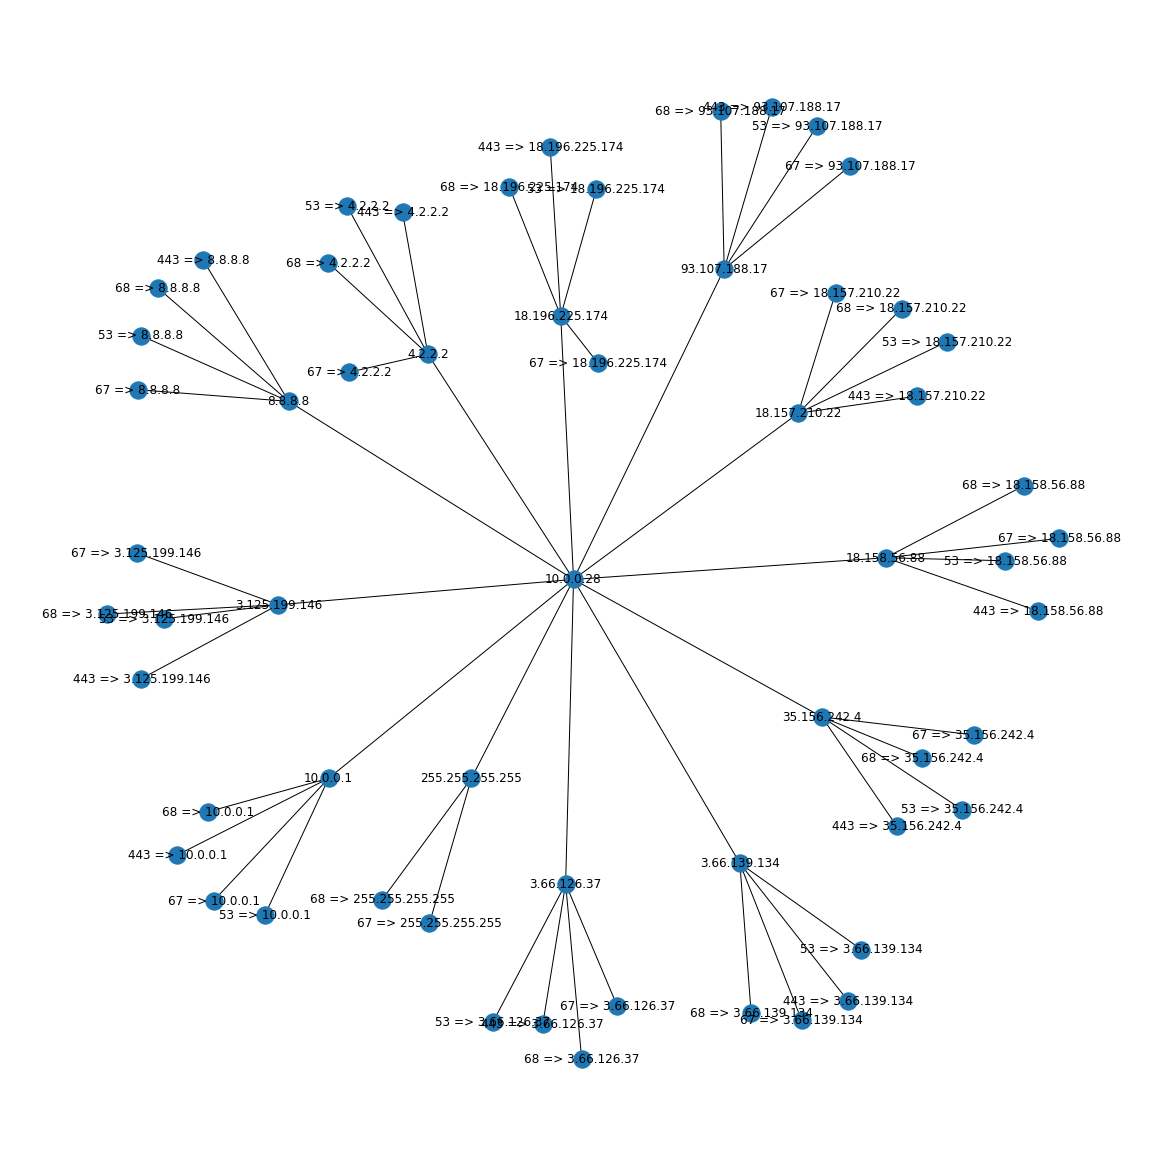

In [197]:
plt.figure(figsize=(16,16))
nx.draw(G, with_labels = True)
plt.show()